In [135]:
import matplotlib.pyplot as plt
import numpy as np

class Sequence:
    def __init__(self):
        # (50,51) are wild jacks
        # (48,49) are anti-wild jacks
        self.deck = np.hstack((np.arange(52),np.arange(52)))

        #represent the current state of the game
        # 0 represents an empty space
        # 1 represents a space with a black token
        # -1 represents a space with a white token
        self.tokens = np.zeros((10,10))

        #randomly assign spaces on the board to cards.
        board = np.concatenate((np.random.choice(self.deck[self.deck<48],len(self.deck)-8,replace=False),
                                [-1]*4)).reshape(10,10)
        board[9,-4:-1] = [board[0,0],board[0,9],board[9,0]]
        board[0,0],board[0,9],board[9,0] = (-1,-1,-1)
        self.board = board
        
        #draw cards for players
        np.random.shuffle(self.deck)
        self.deck_pos = len(self.deck)-1
        self.hands = [self.deck[-5:],self.deck[-10:-5]]
        self.deck_pos -= 10
        self.turn = 1
    
    def play(self, play, player):
        """
        Parameters:
            play (tuple (int,(int,int)) ): play represented by card from hand and location on the board
            player (int): which player is making the move? -1 or 1
        """
        #if legal move
        
        #place or remove token
        if self.hands[(player+1)//2][play[0]] in [48,49]:
            self.tokens[play[1][0],play[1][1]] = 0
        else:
            self.tokens[play[1][0],play[1][1]] = player
        
        #draw card
        self.hands[(player+1)//2][play[0]] = self.deck[self.deck_pos]
        self.deck_pos -= 1

        #if deck is empty
            #reshuffle
        
        #change turns
        self.turn = -1*self.turn
    
    def show_board(self):
        cmap = plt.get_cmap('RdBu', 3)
        plt.matshow(self.tokens,cmap=cmap,vmin=-1,vmax=1)
        plt.colorbar(ticks=np.arange(-1,2))
        plt.show()
    
    def get_moves(self,player):
        moves = list()
        j = 0
        for card in self.hands[(player+1)//2]:
            if card<48:
                locs = np.stack(np.where(np.logical_and(self.board==card,self.tokens==0))).T
            elif card < 50:
                locs = np.stack(np.where(self.tokens==(-1*player))).T
            else:
                locs = np.stack(np.where(self.tokens==0)).T
                #need to consider wild card locations
            
            for loc in locs:
                moves.append((j,loc))
            j += 1
        return moves
        
    #def check_winner(self):
        

In [136]:
game = Sequence()

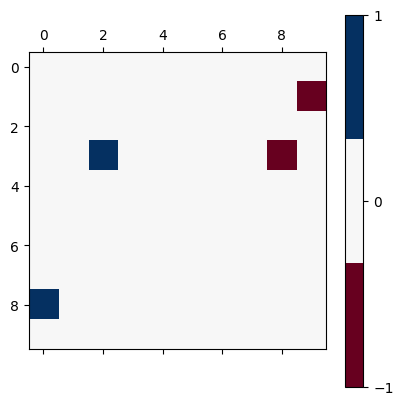

In [157]:
game.show_board()

In [138]:
print(game.board)

[[-1 26  8 24  7 17  0  3 19 -1]
 [34 47  9 18 31 32 22 10 34 12]
 [30 37 14 13 32  2 35 38  7 21]
 [ 4 42 25 27 45  8 15 10 27 46]
 [43 11 12 29  1 11 38  6 29 15]
 [37 22 16 17 44 23 31 23 41 24]
 [ 2 43 19 28 21 40  5 13  9  1]
 [26  4  0 42 16 39 47 36 33 14]
 [35 20 30 46 25 28  5 40 45 18]
 [-1 41 36 33 44 39  3  6 20 -1]]


In [154]:
print(game.tokens)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [140]:
game.hands[1]

array([33, 12, 25, 37, 35])

In [151]:
moves = game.get_moves(1)
moves

[(0, array([7, 8])),
 (0, array([9, 3])),
 (1, array([1, 9])),
 (1, array([4, 2])),
 (2, array([2, 3])),
 (2, array([6, 7])),
 (3, array([2, 1])),
 (3, array([5, 0])),
 (4, array([2, 6])),
 (4, array([8, 0]))]

In [152]:
game.play(moves[np.random.randint(len(moves))],1)

In [155]:
moves = game.get_moves(-1)
moves

[(0, array([7, 5])),
 (0, array([9, 5])),
 (1, array([8, 1])),
 (1, array([9, 8])),
 (2, array([5, 5])),
 (2, array([5, 7])),
 (3, array([1, 9])),
 (3, array([4, 2])),
 (4, array([0, 4])),
 (4, array([2, 8]))]

In [156]:
game.play(moves[np.random.randint(len(moves))],-1)